<a href="https://colab.research.google.com/github/nicholasrichers/feature_selection-neuron/blob/main/Artigo_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artigo Seleção de Variáveis Neuron

**Título: Comparando métodos de seleção de variáveis**

*Subtítulo: Como selecionar quem irá selecionar?*


![](https://images.unsplash.com/photo-1460058418905-d61a1b4a55fe?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1489&q=80)

# Introdução

Seleção de variáveis é uma etapa de pré-processamento encontrado em problemas de aprendizado supervisionado. As principais motivações em diminuir a dimensionalidade do conjunto de dados são diminuir o tempo de treinamento, melhorar a performance do modelo e ainda aprimorar a interpretabilidade destas variáveis.

O objetivo deste artigo é apresentar algumas dessas técnicas (descritas no livro [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089)), apontar quais são suas limitações e oferecer ao leitor uma alternativa que permita comparar essas técnicas e outras que venha a utilizar.





---



---



# Conjunto de dados

Para facilitar o nosso estudo, vamos utilizar um conjunto de dados sintético que nos permita saber de antemão quais variáveis são informativas.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


def get_test_data(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):

    # generate a random dataset for a classification problem    
    X, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative, 
                               n_redundant=n_redundant, 
                               random_state=0, 
                               shuffle=False)
    


    #renaming columns according to type (informative, redundant, noise)
    cols = ['I_%s' % i for i in range(n_informative)] + ['R_%s' % i for i in range(n_redundant)]
    cols += ['N_%s' % i for i in range(n_features - len(cols))]

    #transform array into dataframe
    X = pd.DataFrame(X, columns=cols)
    y = pd.Series(y)
    
    return X, y

> A partir da função `get_test_data()`, criaremos um problema de classificação binária com 40 variáveis, ao qual 10 são informativas, 10 são redundantes (i.e são combinações lineares das colunas informativas), e as 10 restantes são apenas ruído.

In [31]:
X, y = get_test_data()#n_features=12, n_informative=4, n_redundant=4, n_samples=5000)

> Segue abaixo um exemplo com 12 variáveis

In [30]:
X.head()

,I_0,I_1,I_2,I_3,R_0,R_1,R_2,R_3,N_0,N_1,N_2,N_3
0,-3.941539,-1.955124,-1.247683,-0.665536,2.870924,0.706670,-0.144982,-1.498281,-0.229430,0.177231,0.648948,-0.818646
1,-2.882175,-1.822702,-0.568862,0.103451,2.196651,0.966482,-0.527894,-1.100332,0.130209,-0.831310,1.484291,0.320911
2,-1.897824,-0.659752,-0.575968,1.432049,1.647345,0.800773,-0.995133,-1.899108,-1.667659,-0.005389,2.347850,0.202494
3,-2.574587,1.990887,0.383741,3.980372,3.637930,0.773705,-1.803899,-6.490407,0.105738,1.093880,-0.037027,-1.414238
4,-1.885823,-2.601728,-1.325420,-0.736274,0.621126,0.755418,-0.237697,1.156626,-1.178807,0.069023,0.454516,-0.522534


> Dessa forma, independente do método utilizado, esperamos que ele seja capaz de distinguir as variáveis informativas (I) e redundantes (R), das que representam apenas ruído (N).



---



---



# Mean Decrease Impurity (MDI)

O MDI é um método escífico de modelos de árvore, como Random Forest, acessado nativamente através do `scikit-learn` pelo método `feature_importances_`.

Em cada nó de cada árvore um **subconjunto de features é sorteada**, e aquela onde o `split` melhor dividir os dados, ou diminuir mais a impureza é selecionado. Logo podemos concluir que a variável mais vezes selecionada é a melhor.


Esse método possui alguns problemas, uma vez que comumente uma variável de maior cardinalidade possui maior probabilidade de dividir melhor os dados. [Nesse link](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py), vemos um caso onde uma variável de números aleatórios (maior cardinalidade), possui maior `feature_importance`.

A maneira abordada por [1], de resolver esse problema é através do parâmetro `max_features=1`, pois dessa forma apenas uma feature será pré selecionada, garantindo assim que todas sejam selecionadas igualmente.

Outras limitações:

* É um procedimento "in-sample" (IS), não havendo nenhuma garanita de que irá funcionar fora da amostra (out of sample, OOS)

* Ele não resolve problemas relacionados a multicolineariedade. Duas variáveis idênticas, terão sua importância dividida pela metade, uma vez que são selecionadas aleatoriamente com igual probabilidade.

In [4]:
def mean_decrease_impurity(model, feature_names):

    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    importance = pd.concat({'mean': feature_imp_df.mean(),
                            'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5}, axis=1)

    importance /= importance['mean'].sum()
    return importance

In [5]:

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)

def plot_feature_importance(importance_df, oob_score, oos_score):

    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    plt.title('Feature importance. OOB Score:{}; OOS score:{}'.format(round(oob_score, 4), round(oos_score, 4)))
    plt.show()

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer


#setup accuracy as score metric
scorer = make_scorer(accuracy_score)

#fit classifier
clf = RandomForestClassifier(max_features=1, oob_score=True)

#Bagging with 100 Decision trees
#clf_ = DecisionTreeClassifier()
#clf = BaggingClassifier(base_estimator=clf_, n_estimators=100, max_features=1.0, max_samples=1.0, oob_score=True, n_jobs=-1)


fit = clf.fit(X, y)

#get importances dataframe
mdi_importances = mean_decrease_impurity(fit, X.columns)

In [7]:
#get oob & oos scores
oob_score = fit.oob_score_
oos_score = cross_val_score(clf, X, y, cv=3, scoring=scorer).mean()

É fácil perceber que o MDI obteve bons resultados, uma vez que todas as variaveis com ruído (N), figuram nas últimas posições e com uma importância significativamente menor.

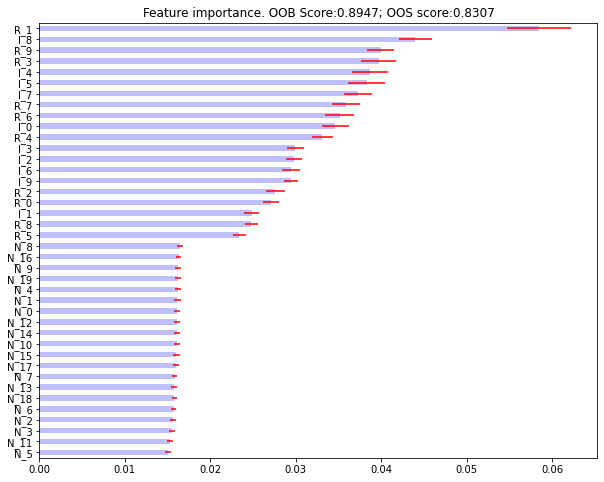

In [8]:
plot_feature_importance(mdi_importances, oob_score=oob_score, oos_score=oos_score)



---



---



# Mean Decrease Accuracy (MDA)

O MDA é um método significativamente mais lento que o anterior, porém é capaz de entregar a importância fora da amostra (OOS).

Essa técnica não é limitada a modelos de árvore e consiste em treinar um classificador/regressor e obter sua performance OOS, de acordo com uma métrica a escolha (usei acurácia). Em seguida iremos permutar (embaralhar) uma variável por vez, treinando um novo modelo e comparando com a performance OOS do modelo original.


Limitações:

* Como o MDI esse procedimento está suscetível a presença de multicolineariedade (presente nas variáveis redundantes)

* Dadas duas variáveis idênticas, o MDA irá considerar que ambas não são importantes, dada a característica do procedimento

In [9]:
from sklearn.metrics import log_loss
def mean_decrease_accuracy(model, X, y, cv_gen, scoring, random_state=42):


    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)

    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)

    #split data
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred)

        feature_sets = [[x] for x in X.columns]
        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA 

            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob, labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred)


    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)


    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [10]:
from sklearn.model_selection import KFold
cv_gen = KFold(n_splits = 3)
mda_importances = mean_decrease_accuracy(clf, X, y, cv_gen, scoring=accuracy_score, random_state=42)

> Podemos ver que o MDA foi afetado pela presença de variáveis reduntantes, uma vez que algumas variáveis informativas (I) foram classificadas abaixo de variáveis com apenas ruído (N).

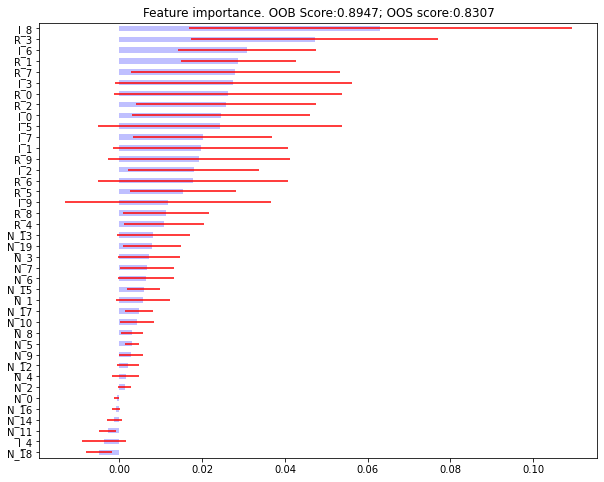

In [11]:
plot_feature_importance(mda_importances, oob_score=oob_score, oos_score=oos_score)

> O artigo [2], cita uma série de outras limitações relacionadas a permutação de variáveis, e sugere alguns métodos como o *Leave one out Covariate (LOCO)* [3]. Outros métodos como Boruta [4], tentam fazer uso das duas técnicas combinadas.



---



---



# Single Feature Importance (SFI)

O método SFI leva em consideração apenas uma variável por vez, descartando os problems relacionados a multicolineariedade.

Limitações:
* Um modelo com duas variáveis pode funcionar melhor com duas variáveis do que juntando 2 modelos (bagging) com apenas uma.

In [12]:
def single_feature_importance(clf, X, y, cv_gen, scoring=log_loss):


    imp = pd.DataFrame(columns=['mean', 'std'])
    for feat in X.columns:
        feat_cross_val_scores = cross_val_score(clf, X=X[[feat]], y=y,scoring=scoring, cv=cv_gen)
        imp.loc[feat, 'mean'] = feat_cross_val_scores.mean()

        # pylint: disable=unsubscriptable-object
        imp.loc[feat, 'std'] = feat_cross_val_scores.std() * feat_cross_val_scores.shape[0] ** -.5
    return imp

In [13]:
sfi_importances = single_feature_importance(clf, X, y, cv_gen, scoring=scorer)

> O modelo com apenas uma feature não funcionou bem, além de haver muitas variáveis informativas do fundo do ranking, a diferença de performance entre elas é sempre bem próxima, além disso nenhuma variável sozinha atingiu 50% de acurácia, o mínimo esperado para um problema de classificação binária.

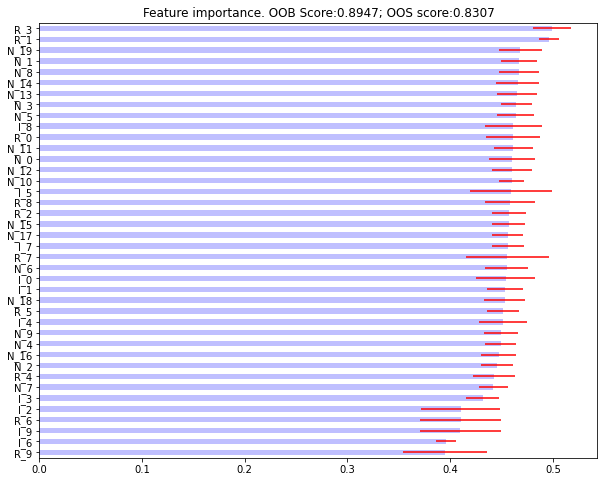

In [14]:
plot_feature_importance(sfi_importances, oob_score=oob_score, oos_score=oos_score)



---



---



# Orthogonalização

Uma maneira de lidarmos parcialmente com os efeitos de subsitituição (multicolineariedade), é ortogonalizando as variáveis aplicando PCA. Essa transformação irá ajudar a aliviar os efeitos de substituição lineares. Atente-se ao fao de que é necessário normalizarmos as variáveis antes de aplicarmos o PCA, por duas razões. (1) Centralizando os dados podemos assegurar que a primeira componente principal (PCA_0) estará corretamente orientada na direção principal das amostras. (2) Ao normalizarmos os dados, o PCA buscará explicar correlações ao invés das variâncias, caso contrário as primenras componentes seriam dominadas pelas variáveis de maior variância.

In [32]:
from scipy.stats import weightedtau, kendalltau, spearmanr, pearsonr


def _get_eigen_vector(dot_matrix, variance_thresh, num_features=None):
    """
    Advances in Financial Machine Learning, Snippet 8.5, page 119.

    Computation of Orthogonal Features

    Gets eigen values and eigen vector from matrix which explain % variance_thresh of total variance.

    :param dot_matrix: (np.array): Matrix for which eigen values/vectors should be computed.
    :param variance_thresh: (float): Percentage % of overall variance which compressed vectors should explain.
    :param num_features: (int) Manually set number of features, overrides variance_thresh. (None by default)
    :return: (pd.Series, pd.DataFrame): Eigenvalues, Eigenvectors.
    """
    # Compute eigen_vec from dot prod matrix, reduce dimension
    eigen_val, eigen_vec = np.linalg.eigh(dot_matrix)
    idx = eigen_val.argsort()[::-1]  # Arguments for sorting eigen_val desc
    eigen_val, eigen_vec = eigen_val[idx], eigen_vec[:, idx]

    # 2) Only positive eigen_vals
    eigen_val = pd.Series(eigen_val, index=['PC_' + str(i + 1) for i in range(eigen_val.shape[0])])
    eigen_vec = pd.DataFrame(eigen_vec, index=dot_matrix.index, columns=eigen_val.index)
    eigen_vec = eigen_vec.loc[:, eigen_val.index]

    # 3) Reduce dimension, form PCs
    cum_var = eigen_val.cumsum() / eigen_val.sum()
    if num_features is not None: # Either a preset number of features
        dim = num_features - 1
    else: # Or defined by variance level
        dim = cum_var.values.searchsorted(variance_thresh)
    eigen_val, eigen_vec = eigen_val.iloc[:dim + 1], eigen_vec.iloc[:, :dim + 1]
    return eigen_val, eigen_vec


def _standardize_df(data_frame):
    """
    Helper function which divides df by std and extracts mean.

    :param data_frame: (pd.DataFrame): Dataframe to standardize
    :return: (pd.DataFrame): Standardized dataframe
    """
    return data_frame.sub(data_frame.mean(), axis=1).div(data_frame.std(), axis=1)


def get_orthogonal_features(feature_df, variance_thresh=.95, num_features=None):
    """
    Advances in Financial Machine Learning, Snippet 8.5, page 119.

    Computation of Orthogonal Features.

    Gets PCA orthogonal features.

    :param feature_df: (pd.DataFrame): Dataframe of features.
    :param variance_thresh: (float): Percentage % of overall variance which compressed vectors should explain.
    :param num_features: (int) Manually set number of features, overrides variance_thresh. (None by default)
    :return: (pd.DataFrame): Compressed PCA features which explain %variance_thresh of variance.
    """
    # Given a dataframe of features, compute orthogonal features
    feature_df_standard = _standardize_df(feature_df)  # Standardize
    dot_matrix = pd.DataFrame(np.dot(feature_df_standard.T, feature_df_standard), index=feature_df.columns,
                              columns=feature_df.columns)
    _, eigen_vec = _get_eigen_vector(dot_matrix, variance_thresh, num_features)
    pca_features = np.dot(feature_df_standard, eigen_vec)
    return pca_features

In [49]:
Xdot = get_orthogonal_features(X, variance_thresh=.95, num_features=None)
Xdot = pd.DataFrame(Xdot, columns=pca_columns)

In [50]:
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,-2.247346,3.289565,-1.367301,-2.863059,-1.412666,-0.799908,0.213012,0.331433,0.866300,0.032951,-2.996616,0.363532,-0.166937,1.426407,0.760479,0.869171,0.873983,-0.013344,1.944196,-0.481867,0.060209,-0.277116,-0.534618,0.986281,-0.384909,-0.801349,0.828607,1.121230
1,-0.956982,-0.370077,-0.070016,-3.012735,0.317126,0.332048,-0.771460,-0.385234,0.124513,0.067744,-0.801131,-0.600267,-0.506707,-0.083286,-0.262854,-0.628384,-1.401245,0.030920,-0.769808,-1.209847,-0.564018,-0.825132,0.753131,-0.379044,-0.456504,1.176804,-0.593204,-0.354478
2,-4.432080,2.690585,1.475541,-1.157080,0.586217,0.561810,0.509762,-1.904502,1.081916,1.208494,1.799926,-0.247350,0.928283,1.124757,0.190414,1.286317,-0.650261,-0.718204,-0.449401,0.567609,-0.040427,-0.911582,0.271040,-0.410972,2.323971,0.226183,2.398908,0.385578
3,2.366804,-1.419525,0.356341,0.679244,2.952952,0.414377,0.889363,2.163380,0.454700,1.256352,-1.194468,-0.094978,0.247717,0.064863,-0.822352,-0.320128,0.153822,2.213973,2.320637,0.228787,1.007314,-1.230794,0.694026,1.360371,-0.970620,1.304913,-1.543305,0.018166
4,1.104342,-0.693122,-0.555143,-1.283740,0.570558,-0.309020,-2.019225,-0.153222,0.867766,-0.339598,-0.647160,0.193531,-0.833451,1.318121,-0.257649,0.412327,0.815966,-1.099798,-2.428816,0.200491,-1.533220,-0.077449,1.194174,-0.406989,-1.561206,-0.957596,-0.192124,2.333219


> MDI + PCA

In [52]:
fit_ = clf.fit(Xdot, y)
mdi_dot_importances = mean_decrease_impurity(fit_, Xdot.columns)

In [53]:
#get oob & oos scores
oob_score_pca = fit_.oob_score_
oos_score_pca = cross_val_score(clf, Xdot, y, cv=3, scoring=scorer).mean()

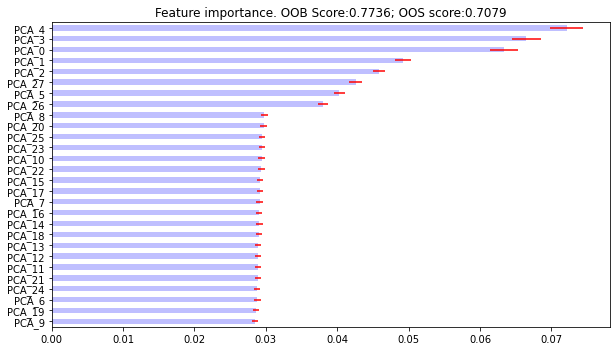

In [54]:
plot_feature_importance(mdi_dot_importances, oob_score=oob_score_pca, oos_score=oos_score_pca)

> MDA + PCA

In [55]:
mda_dot_importances = mean_decrease_accuracy(clf, Xdot, y, cv_gen, scoring=accuracy_score, random_state=42)

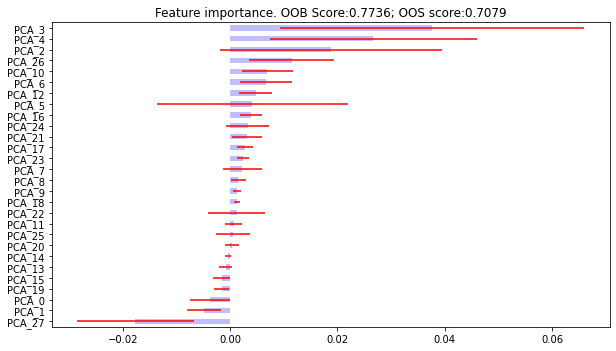

In [56]:
plot_feature_importance(mda_dot_importances, oob_score=oob_score_pca, oos_score=oos_score_pca)

> SFI + PCA

In [58]:
sfi_dot_importances = single_feature_importance(clf, Xdot, y, cv_gen, scoring=scorer)

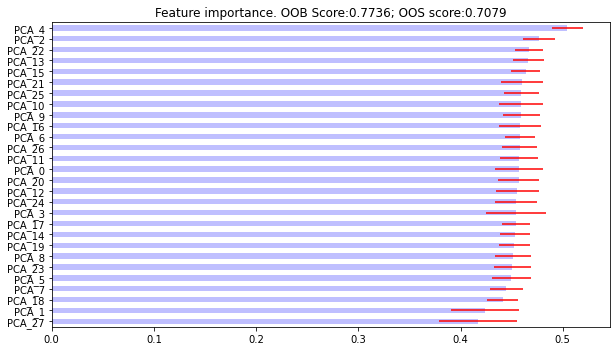

In [59]:
plot_feature_importance(sfi_dot_importances, oob_score=oob_score_pca, oos_score=oos_score_pca)



---



---



# Comparando métodos

Devemos sempre ser céticos sobre as variáveis supostamente importantes identificada por qualquer método. Agora lembre-se que ao extrair as componentes principais, isso foi feito de maneira **não supervisionada**, ao contrário dos métodos citados ao longo do texto (supervisionados). 

Quando algum metodo supervisionado (MDI, MDA, SFI...), seleciona as mesmas variáveis que o PCA determinou como as principais de maneira não supervisionada, temos uma evidência que o padrão encontrado pelo método supervisionado não é overfitting.

In [25]:

def feature_pca_analysis(feature_df, feature_importance, variance_thresh=0.95):
    """
    Performs correlation analysis between feature importance (MDI for example, supervised) and PCA eigenvalues
    (unsupervised).

    High correlation means that probably the pattern identified by the ML algorithm is not entirely overfit.

    :param feature_df: (pd.DataFrame): Features dataframe.
    :param feature_importance: (pd.DataFrame): Individual MDI feature importance.
    :param variance_thresh: (float): Percentage % of overall variance which compressed vectors should explain in PCA compression.
    :return: (dict): Dictionary with kendall, spearman, pearson and weighted_kendall correlations and p_values.
    """
    feature_df_standard = _standardize_df(feature_df)  # Standardize
    dot = pd.DataFrame(np.dot(feature_df_standard.T, feature_df_standard), index=feature_df.columns,
                       columns=feature_df.columns)
    eigen_val, eigen_vec = _get_eigen_vector(dot, variance_thresh)

    corr_dict = {}  # Dictionary containing correlation metrics


    # Get Rank based weighted Tau correlation
    # Sum of absolute values across all eigen vectors
    feature_pca_rank = (eigen_val * eigen_vec).abs().sum(axis=1).rank(ascending=False)  
    corr_dict['Weighted_Kendall_Rank'] = weightedtau(feature_importance['mean'].values, feature_pca_rank.values **-1.0)
    return corr_dict


> Faremos essa comparação analisando a correlação das importâncias obtidas pelos método supervisionados com o ranking da projeção das importâncias obtidas pelos PCA. Esse ranking é obtido pela soma do módulo da multiplicação entre os autovalores e autovetores, que pode ser entendido com a soma das distâncias de cada componente na variável original.

```
feature_pca_rank = (eigen_val * eigen_vec).abs().sum(axis=1).rank(ascending=False)
```



In [70]:
feature_df_standard = _standardize_df(X)  # Standardize
dot = pd.DataFrame(np.dot(feature_df_standard.T, feature_df_standard), index=X.columns, columns=X.columns)
eigen_val, eigen_vec = _get_eigen_vector(dot, 0.95)

(eigen_val * eigen_vec).head()#.sum(axis=1)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28
I_0,-18388.176025,449.610124,479.606375,270.356165,-1.937312,571.387564,-360.157969,37.782163,-294.154812,-109.978836,319.990490,54.423374,255.775186,-404.947123,-233.484076,-433.199931,52.625498,175.865606,206.529800,35.758383,302.865319,-540.630731,152.811841,114.002252,187.459057,-663.865206,1348.037980,65.845559
I_1,-8132.997212,-8996.454079,-5157.428088,1113.702333,-5995.252549,-6690.225442,6.391452,-90.113353,-207.544334,-70.152977,-252.046721,91.866701,-162.919365,110.858921,-25.830667,-126.691456,195.875961,84.538247,-69.931892,-100.661310,74.432886,77.552046,85.926252,375.550519,120.126514,379.024940,-562.445099,1593.445102
I_2,8021.056805,-9211.572807,-7877.063469,-6626.313654,3402.157041,-970.321572,-199.394763,-252.124773,-383.677523,-63.764676,71.819647,-64.285518,170.168708,101.195037,80.976102,-105.626216,188.136935,53.028909,-30.240639,422.817450,-127.413982,167.858968,-97.764647,233.516041,-214.707520,-60.041769,158.544463,-1163.152618
I_3,4599.587352,-10440.002492,6784.213879,4082.517120,2934.607704,-3071.626938,-65.868190,693.013353,-545.908676,-409.728204,727.454647,454.048303,580.693505,-667.120610,-368.143206,-444.466380,-609.254841,319.236337,416.597401,-409.024030,321.921316,-1648.319960,623.201507,31.434314,1218.645175,-1698.424969,3721.240840,-103.543432
I_4,-9012.567393,262.645147,1116.820214,-1857.330454,10592.508045,-1767.740357,214.102447,-372.715563,355.788327,166.137135,-513.497070,-167.948297,-613.364200,626.060140,283.837264,198.770454,745.323793,-237.478737,-365.783724,110.322663,-348.502002,1033.081003,-428.158085,-135.054298,-637.482323,1448.682409,-2627.653486,931.097545


## Calculando a correlação


A correlação de postos de [kendall](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_tau_de_Kendall) ($\tau$), é similar a correlação de spearman ($\rho$), a diferença está no calculo do coeficiente ($\tau$), que leva em consideração o ranking relativo de cada par.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/142addc9f83096097389a80932168f9f611b8eda)


![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Concordant_Points_Kendall_Correlation.svg/330px-Concordant_Points_Kendall_Correlation.svg.png)



Nesse contexto, a vantagem de utilizarmos este coeficiente de correlação é a possiblidade de calcularmos o coeficiente ($\tau$), de maneira ponderada, dando um peso para cada par avaliado, ou seja  as variáveis de maior importância possuem maior peso, assim não precisamos nos preocupar com a ordenação de variáveis de menor importância.

$$
Weight = \frac{1}{(r+1)} + \frac{1}{(s+1)}
$$

Onde $r$ e $s$, são os rankings relativos de cada variável. Felizmente o *Weighted Tau* é encontrado na biblioteca [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weightedtau.html).

> Perceba que apesar do coeficiente ($\tau$) não apresentar valores muito altos, apresentaram resultados próximos a intuição que obtivemos ao observamos a ordem relativa das variáveis informativas e ruidosas. A grande diferença é que em um dataset não sintético, nao teremos essa distinção de maneira clara.

In [26]:
feature_pca_analysis(X, mdi_importances.reindex(X.columns), variance_thresh=.99)

{'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.31191037058665727, pvalue=nan)}

In [27]:
feature_pca_analysis(X, mda_importances.reindex(X.columns), variance_thresh=.99)

{'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.2965247735591309, pvalue=nan)}

In [28]:
feature_pca_analysis(X, sfi_importances.reindex(X.columns), variance_thresh=.99)

{'Weighted_Kendall_Rank': WeightedTauResult(correlation=-0.10441690103565301, pvalue=nan)}



---



---



Referencias:


[1] https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089

[2] https://arxiv.org/abs/1905.03151

[3] https://compstat-lmu.github.io/iml_methods_limitations/pfi.html

[4] https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

[5] https://medium.com/swlh/feature-selection-techniques-to-make-better-generalization-models-6a19dd6dc9b1


Link para o notebook: https://github.com/nicholasrichers/feature_selection-neuron/blob/main/Artigo_Feature_selection.ipynb

> E aí, o que achou? Fique a vontade para entrar em contato nas minhas redes sociais [Twitter](https://twitter.com/NickRichers), [Linkedin](https://www.linkedin.com/in/nicholas-richers/).